# Progress Report for PH4419
### A short study on the behaviour of ferromagnetism

I am working on a simulation of the square lattice Ising model. Each element in the lattice contains a value of either spin up (+1) or spin down (-1). Each spin only interacts with its direct neighbours. We set the boundary conditions up as a torus where spins on opposite geometric edges are considered as neighbours. This model allows us to study the phase transition in ferromagnetic materials using statistical physics. To simplify the model, we will work with natural units and set the constants $J$ and $k_B$ to one. For this study, we will assume that there is no external magnetic field. The two-dimensional Ising model without an external field has already been analytically solved by Lars Onsagers.

Onsagers showed that the model undergoes a phase transition at the critical temperature
\begin{equation}
    T_C = \frac{2}{\log (\sqrt{2} + 1)} \approx 2.27
\end{equation}

The energy $e$ at one specific site $(i,j)$ on a lattice $S$ is given by
\begin{equation}
    e(i,j) = -S(i,j) \cdot [S(i+1,j) + S(i-i,j) + S(i,j+1) + S(i,j-1)].
\end{equation}

The total energy $E$ is just the sum of all spin sites on the lattice
\begin{equation}
    E = \sum_{i,j}^N e(i,j).
\end{equation}

The total magnetization $M$ of the lattice is given by
\begin{equation}
    M = \sum_{i,j}^N S(i,j).
\end{equation}

The specific heat $C_v$ of the lattice is given by
\begin{equation}
    C_v = \frac{1}{T^2} \left[\langle E^2 \rangle - \langle E \rangle ^2 \right]
\end{equation}

The magnetic susceptibility $\chi$ of the lattice is given by
\begin{equation}
    \chi = \frac{1}{T} \left[\langle M^2 \rangle - \langle M \rangle ^2 \right]
\end{equation}

The change in energy $dE$ for flipping one spin site is given by 
\begin{equation}
    dE = -2 e(i,j) = 2 S(i,j) \cdot [S(i+1,j) + S(i-i,j) + S(i,j+1) + S(i,j-1)]
\end{equation}
Hence the maximum energy change per flip is $\pm 8$.

The Ising model will take a long time to solve numerically since the number of possible states for a $N$ by $N$ square lattice is $2^N$. The Ising model is often simulated using the Monte Carlo method and the most used algorithm is the Metropolis-Hastings algorithm. The Metropolis algorithm is used to determine if a spin flips. The steps of the algorithm are as follow
<ol>
    <li> Randomly select a spin site on the lattice. </li>
    <li> Compute the change in energy $dE$ when the spin is flipped. </li>
    <li> If $dE \leq 0$, the spin is flipped with probability 1. </li>
        <li> If $dE > 0$, the spin is flipped with the probability $\exp{\frac{-dE}{T}}$.</li>
</ol>

We begin our simulation by initialize a state where all spins sites in the lattice are aligned. The starting temperature is $T=1.0$ and the temperature is slowly increased at each time step by $dT = 0.01$, to a final temperature of $T=5.0$. At each temperature step, we will calculate the values of $E,M,C_v,\chi$ and plot them at the end against temperature. We would also set up an animation at the time to show the evolution of the lattice spin state against temperature.

The Lattice class contains all the attributes (size of lattice, temperature, total energy and total magnetization) related to the simulation. The Figure class contains methods for normalizing the observable data, plotting the graphs and animating the lattice evolution.

In [76]:
## import modules
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

## define Lattice class
class Lattice:
    def __init__(self, N, T):
        self.N = N ## lattice size
        self.T = T ## temperature
        self.M = 0 ## total magnetization
        self.E = 0 ## total energy
        self.array = np.ones((self.N,self.N), dtype=int) ## all spins are aligned
        self.E_total() ## total energy  
        self.M_total() ## total magnetization
        self.E_list = [] ## list that holds energy values
        self.M_list = [] ## list that holds magnetization values
        
    ## calculate energy of a lattice site
    ## we assume boundary boundary conditions (torus like)
    def calculate_energy(self,i,j):
        e = self.array[(i+1)%self.N,j] + self.array[(i-1)%self.N,j] + self.array[i,(j+1)%self.N] + self.array[i,(j-1)%self.N]
        return(-1.0*self.array[i,j]*e)
    
    ## total energy of lattice
    def E_total(self):
        e = 0
        for i in range(self.N):
            for j in range(self.N):
                e += self.calculate_energy(i,j)
        self.E = e
    
    ## total magnetization of lattice
    def M_total(self):
        self.M = np.sum(self.array)
        
    ## metropolis algorithm
    def metropolis(self,steps):
        for n in range(steps):
            ## select a random lattice site
            i,j = np.random.randint(0,self.N),np.random.randint(0,self.N)
            dE = -2.0*self.calculate_energy(i,j)
            
            if dE <= 0:
                ## flip spin
                self.array[i,j] *= -1
                self.E += dE
                self.M += 2*self.array[i,j]
                self.M_list.append(self.M)
                self.E_list.append(self.E)
                
            elif np.random.rand() < np.exp(-1.0*dE/self.T):
                self.array[i,j] *= -1
                self.E += dE
                self.M += 2*self.array[i,j]
                self.M_list.append(self.M)
                self.E_list.append(self.E)
    
    
    def get_neighbours(self,i):
        return [((i-1)%self.N),((i+1)%self.N),((i-self.N)%self.N),((i+self.N)%self.N)]

    def get_cluster(self, i, temp, cluster, visited):
        ## convert 2d array into 1d array
        config = np.ravel(self.array)
        ## get spin of random site
        spin = config[i]
        ## get neighbours of spin site
        neighbours = self.get_neighbours(i)
        ## append spin site into cluster and visited list
        cluster.append(i)
        visited.append(i)
        
        ## check against all neighbours
        for n in neighbours:
            ## if neighbour's spin and random spin site match
            if config[n] == spin:
                ## check that we did not visit the spin site before
                if n not in visited:
                    prob = 1 - np.exp(-2.0/(self.T))
                    ## append neighbour to cluster if it satisifies the probability
                    if np.random.rand() > prob:
                        cluster = self.get_cluster(n, self.T, cluster, visited)
        return cluster

        
    def wolff_algo(self,steps):
        ## convert 2d array into 1d array
        config = np.ravel(self.array)
        
        def flip_cluster(self, cluster):
            for i in cluster:
                ## flip spin (+/- 1 to -/+ 1)
                config[i] *= -1
        
        for n in range(steps):
            ## select a random lattice site
            i = np.random.randint(0,self.N)
            ## get cluster based on spin site
            cluster = self.get_cluster(i, self.T, [], [])\
            ## flip everything in the cluster
            flip_cluster(self, cluster)
        
        ## convert 1d array back to 2d array
        array = np.array(config)
        self.array = array.reshape((self.N, self.N))




In [70]:
## define Figures class
class Figures:
    def __init__(self,N=16,t_start=1.0,t_end=5.0,dt=0.1,steps=50000,T=1.0):
        self.N = N
        self.dt = dt
        self.t_start = t_start
        self.t_end = t_end
        self.dt = dt
        self.steps = steps
        self.T = T
        self.title='$N={}$, $T_i={}$, $T_f={}$, $dT={}$, Steps={}'.format(self.N,self.t_start,self.t_end,self.dt,self.steps)
    
    ## normalize array to proper values
    def normalize_array(self,array):
        return [1.0*i/(self.N*self.N) for i in array]
    
    ## calculate specific heat at a given temperature
    def calculate_cv(self,E_list,T):
        ## avgE = <E>, avgE2 = <E>^2
        avgE = np.average(E_list)
        avgE2 = avgE*avgE
        ## avg_E2 = <E^2>
        avg_E2 = sum([i*i  for i in E_list])/len(E_list)
        C = (1.0/(self.N*self.N)) * ((1.0/T)**2) * (avg_E2-avgE2)
        return C
    
    ## calculate magnetic susceptibility at a given temperature
    def calculate_mag_sus(self,M_list,T):
        avgM = np.average(M_list)
        avgM2 = avgM*avgM
        avg_M2 = sum([i*i for i in M_list])/len(M_list)
        X = (1.0/(self.N*self.N)) * (1.0/T) * (avg_M2-avgM2)
        return X
    
    ## plot observables wrt temperature
    def plot(self):
        fig,ax = plt.subplots(figsize=(7,4))
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.title(self.title)
        ax.scatter(np.arange(self.t_start,self.t_end,self.dt), self.data, c=self.c)
        ## scale y axis
        dy = (max(self.data) - min(self.data))*0.1
        ax.set_ylim(min(self.data)-dy, max(self.data)+dy)
        plt.show()
    
    ## calculate energy wrt temperature
    def energy(self):
        T_list = []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = Lattice(self.N, T)
            lattice.metropolis(self.steps)
            T_list.append(np.average(lattice.E_list))
        self.data = Figures.normalize_array(self,T_list)
        self.xlabel = 'Temperature (T)'
        self.ylabel = 'Energy'
        self.c = 'red'
        Figures.plot(self)
    
    ## calculate specific heat wrt temperature
    def specific_heat(self):
        T_list = []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = Lattice(self.N, T)
            lattice.metropolis(self.steps)
            T_list.append(Figures.calculate_cv(self, lattice.E_list, T))
        self.data = Figures.normalize_array(self,T_list)
        self.xlabel = 'Temperature (T)'
        self.ylabel = 'Specific Heat $C_V$'
        self.c = 'red'
        Figures.plot(self)
    
    ## calculate magnetization wrt temperature
    def mag(self):
        T_list = []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = Lattice(self.N, T)
            lattice.metropolis(self.steps)
            T_list.append(np.abs(np.average(lattice.M_list)))
        self.data = Figures.normalize_array(self,T_list)
        self.xlabel = 'Temperature (T)'
        self.ylabel = 'Magnetization'
        self.c = 'blue'
        Figures.plot(self)

    ## calculate magnetic susceptibility wrt temperature
    def mag_sus(self):
        T_list = []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = Lattice(self.N, T)
            lattice.metropolis(self.steps)
            T_list.append(Figures.calculate_mag_sus(self, lattice.M_list, T))
        self.data = Figures.normalize_array(self,T_list)
        self.xlabel = 'Temperature (T)'
        self.ylabel = 'Magnetic susceptibility $\chi$'
        self.c = 'blue'
        Figures.plot(self)
    
    ## animates lattice evolution wrt temperature
    ## plots last state of lattice    
    def lattice_by_temp(self):
        fig = plt.figure()
        Z, img = [], []
        for T in np.arange(self.t_start,self.t_end,self.dt):
            lattice = Lattice(self.N, T)            
            lattice.metropolis(self.steps)
            self.array = lattice.array
            Z.append(self.array)
        for i in range(len(Z)):
            img.append([plt.imshow(Z[i])])
        ani = animation.ArtistAnimation(fig, img, interval=200, blit=False)
        return HTML(ani.to_html5_video())


        

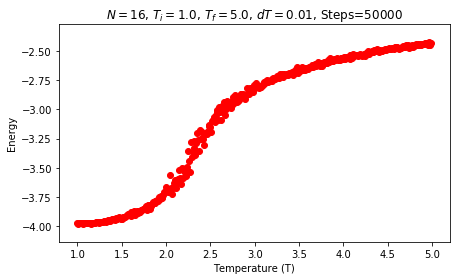

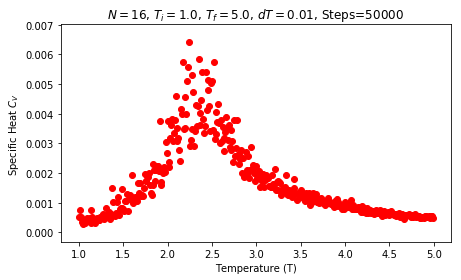

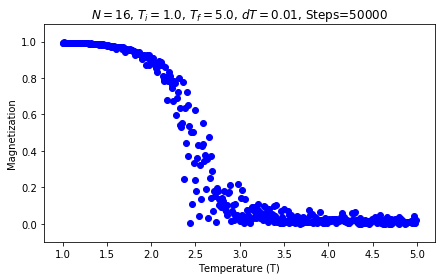

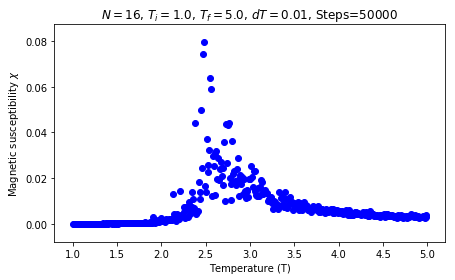

CPU times: user 14min 6s, sys: 7.68 s, total: 14min 14s
Wall time: 14min 33s


In [107]:
%%time
P = Figures(N=16,dt=0.01)
P.energy()
P.specific_heat()
P.mag()
P.mag_sus()

CPU times: user 5min 31s, sys: 6.59 s, total: 5min 37s
Wall time: 1h 6min 39s


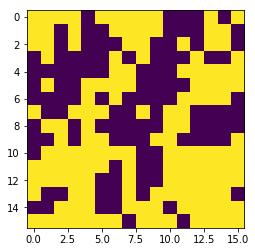

In [111]:
%%time
P.lattice_by_temp()

At temperatures much higher than $T_C$, the system has zero magnetization and is in its highest energy state. At low temperatures, there are very little thermal fluctuations since all the spins were aligned and the system was in its lowest energy state and highest magnetization state.

At $T_C$, the system becomes paramagnetic, we can observe that the magnetization quickly reduces from 1 to 0. We can further analyse this phase transition by observing the specific heat and magnetic susceptibility. At low temperatures, $\chi$ is near 0 since the system was in a low energy state and does not have enough energy to allow the spins to flip. When the temperature is approaching $T_C$, we observe an increase in $\chi$ as the system now has enough energy to allow for spin flips. At $T_C$,  $\chi$ is at its maximum value, and the system undergoes a phase transition. At temperatures above $T_C$, thermal fluctuations of the system tend to dominate and hence, we observe a decrease in $\chi$. The same reasoning goes to $C_V$.

In the following half of the project, we would try to implement Cython into our program since Python is a very slow programming language. We would try and optimize our code and improve its run time. Also, we would try to implement to Wolff algorithm and study the phase transition since the Metropolis algorithm undergoes 'critical slowing down' at temperatures about the critical temperature.
<img src="https://i.imgur.com/41lnzWI.png">